In [1]:
#import library
import re
import emoji
import sklearn
from langdetect import detect
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

nltk.download("wordnet")

c:\users\vernonkoohx\appdata\local\programs\python\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [2]:
#check some library version
print(emoji.__version__)
print(sklearn.__version__)

2.9.0
1.3.2


# File Reading

In [3]:
#define training and testing dataset path
trainData_path = './mediaeval-2015-trainingset.txt'
testData_path =  './mediaeval-2015-testset.txt'

In [4]:
#read training and testing file
trainFile=open(trainData_path,encoding='utf-8')
testFile=open(testData_path,encoding = 'utf-8')

trainheader =trainFile.readline().strip().split('\t')
traindata = trainFile.readlines()
traindataList = list()

testheader =testFile.readline().strip().split('\t')
testdata = testFile.readlines()
testdataList = list()

for line in traindata:
  preprocessed_train_data = line.replace('"', '').strip().split('\t')
  traindataList.append(preprocessed_train_data)
    
for line in testdata:
    preprocessed_test_data = line.replace('"', '').strip().split('\t')
    testdataList.append(preprocessed_test_data)

print(trainheader[0])
print(len(testheader))


tweetId
7


In [5]:
#converting training data into a dataframe
train_data_dict = dict()
test_data_dict = dict()

for column in trainheader:
  train_data_dict[column]=[]

for entry in traindataList:
  for i,value in enumerate(entry):
     train_data_dict[trainheader[i]].append(value)
        
        
for column in testheader:
  test_data_dict[column]=[]

for entry in testdataList:
  for i,value in enumerate(entry):
     test_data_dict[testheader[i]].append(value)
        
df = pd.DataFrame(train_data_dict)
df.head(5)

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


# Data Cleaning

In [6]:
#check any null in training dataset
df['tweetText'].isnull().sum()

0

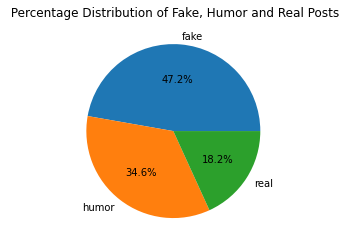

In [7]:
#plot the distribution of label
plt.pie(df['label'].value_counts(), labels=df['label'].unique().tolist(), autopct='%1.1f%%')
plt.title(" Percentage Distribution of Fake, Humor and Real Posts")
plt.show()

2633
0


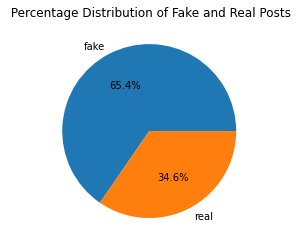

In [8]:
# convert humor into fake label to simplify task into binary classification
def changeLabel(label):
    if label == 'humor':
        label ='fake'
    else:
        pass
    return label

print((df['label']=='humor').sum())
df['label']=df['label'].apply(changeLabel)
print((df['label']=='humor').sum())
plt.pie(df['label'].value_counts(), labels=df['label'].unique().tolist(), autopct='%1.1f%%')
plt.title(" Percentage Distribution of Fake and Real Posts")
plt.show()

In [9]:
# detect different languages in training dataset
language_dict=dict()

def languageDetect(corpus):
    for sentence in corpus:
        try:
            language = detect(sentence)
            if language not in language_dict.keys():
                language_dict[language]=1
            else:
                language_dict[language]=language_dict[language]+1
        except:
            pass   
                
languageDetect(df['tweetText'].tolist())
print(language_dict)


{'es': 1291, 'en': 11154, 'sq': 7, 'ru': 61, 'it': 102, 'no': 34, 'fr': 218, 'bg': 8, 'nl': 93, 'pt': 162, 'de': 123, 'tl': 320, 'pl': 39, 'id': 182, 'cy': 128, 'ja': 21, 'ar': 81, 'vi': 13, 'et': 14, 'ca': 35, 'hu': 6, 'sv': 47, 'so': 115, 'fi': 14, 'af': 62, 'sk': 10, 'el': 5, 'da': 28, 'lt': 4, 'he': 1, 'hr': 6, 'ko': 7, 'tr': 33, 'zh-cn': 10, 'ro': 4, 'fa': 2, 'sl': 6, 'sw': 11, 'th': 19, 'cs': 3, 'mk': 1, 'hi': 1, 'lv': 1}


In [10]:
#countlist=list(language_dict.values())
#sum(countlist)

Text(0.5, 1.0, 'Text Language Distribution')

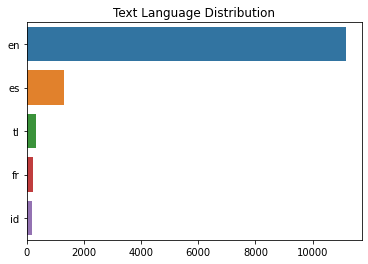

In [11]:
#plot the top 10 languages used
language = list()
language_count = list()

sorted_language_dict = sorted(language_dict.items(), key=lambda x:x[1],reverse=True )
for keyValue in sorted_language_dict:
    lang,lang_count = keyValue
    language.append(lang)
    language_count.append(lang_count)

sns.barplot(x=language_count[:5],y=language[:5])

plt.title('Text Language Distribution')


In [12]:
#drop duplicate if any and reset the index after removal
df = df.drop_duplicates(subset=['tweetText'],keep='first')
df = df.reset_index(drop=True)  #reset index after remove duplicates
df

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake
...,...,...,...,...,...,...,...
12537,443231991593304064,@BobombDom *slaps TweetDeck with the PigFish h...,2179310905,pigFish_01,Da_Vault_Hunter,Tue Mar 11 03: 48: 36 +0000 2014,fake
12538,443086239127076865,New Species of Fish found in Brazil or just Re...,254843101,pigFish_01,DjSituation_RC,Mon Mar 10 18: 09: 26 +0000 2014,fake
12539,442978105238753280,What do we call this? #pigFISH http: \/\/t.co\...,2367553228,pigFish_01,Vivo1Vuyo,Mon Mar 10 10: 59: 45 +0000 2014,fake
12540,442753479782989824,Pigfish ? E dopo il pescecane c'è il pesce mai...,603120231,pigFish_01,CosimoTarta,Sun Mar 09 20: 07: 10 +0000 2014,fake


In [13]:
# create a new dataframe named truncated_df that consists only of the tweetText and label
truncated_df=df.copy()
column_names = ['tweetText','label']   
for column in truncated_df.columns:
  if column not in column_names:
    truncated_df.drop(column,axis=1,inplace=True)
    
truncated_df.tail(30)

,tweetText,label
12512,MH370 has been found. They are all safe :) htt...,fake
12513,MH370 has finally been found!!!! Woot woot!! h...,fake
12514,@ZakiEzarik: MH370 found ..LOL http://t.co/MS9...,fake
12515,MH370 found ..LOL http://t.co/9rsOdub8oF,fake
12516,They found flight MH370!!!!! Lol http://t.co/R...,fake
12517,Tak lawak pukimak cibai . \n\n“@SYAFIQBAKHARI:...,fake
12518,MH370 selamat mendarat dilapangan Batu Berenda...,fake
12519,Una aplicación para tener diversión... ¿la usa...,fake
12520,"Utiliser son iPhone en étant bourré ? LIVR, UN...",fake
12521,Liver un facebook para cuando andas pedo http:...,fake


In [14]:
# collection of text preprocessing function
def emoji_to_text(text):
    # Convert emojis to text with underscores
    text_with_underscores = emoji.demojize(text)
    # Replace underscores with spaces
    text_with_spaces = text_with_underscores.replace('_', ' ')
    return text_with_spaces

def clean_text(text):
    text = emoji_to_text(text)  # Transform emojis to text
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http.*', ' ', text)  # Remove URLs
    text = re.sub(r'@\S+', ' ', text)  # Remove user @ references
    text = re.sub(r'#', '  ', text)  # Remove '#'
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters retaining numbers
    text = ' '.join([word for word in text.split()])
    #text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    return text

def language_translate(text):
    text=GoogleTranslator(source='auto',target='en').translate(text)
    return text

def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join(lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text))

def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    return text

In [15]:
#apply text cleaning
truncated_df['tweetText']=truncated_df['tweetText'].apply(clean_text)

In [16]:
#check for the last 30 items in truncated_df dataframe
truncated_df.tail(30)

,tweetText,label
12512,mh370 has been found they are all safe,fake
12513,mh370 has finally been found woot woot,fake
12514,mh370 found lol,fake
12515,mh370 found lol,fake
12516,they found flight mh370 lol,fake
12517,tak lawak pukimak cibai nn mh370 telah dijumpa...,fake
12518,mh370 selamat mendarat dilapangan batu berenda...,fake
12519,una aplicación para tener diversión la usarías,fake
12520,utiliser son iphone en étant bourré livr une a...,fake
12521,liver un facebook para cuando andas pedo,fake


In [17]:
# list all the stopwords
stops = set(stopwords.words('english'))
print(stops)

{'by', 'himself', 'are', 'ours', 'very', 'over', 'after', 'doing', 'aren', 'yourself', 'am', 'between', 'can', "didn't", 'your', 'all', 've', 'myself', 'hadn', 'against', "you'd", "aren't", "you'll", 'not', 'themselves', 'should', 'both', 'won', 'the', 'o', 'once', 'it', "shan't", 'who', 'where', 'has', 'i', 'is', 'don', 'haven', 'needn', 'herself', 'were', 'theirs', 'but', 'isn', 'in', "don't", 'own', 'shouldn', 'now', 'to', 'such', 'just', 'from', 'its', 'll', 'she', "needn't", 'shan', "you've", 'yours', 'they', 'those', "should've", 'her', 'been', 'until', 'few', "wasn't", 'that', "mightn't", 'ma', 'be', 'our', 'have', 'other', 'hasn', 'we', "wouldn't", 'wasn', 'again', "you're", 'mustn', 're', 'was', 'with', "she's", 'do', 'whom', 'their', 'off', 'what', 'which', 'hers', 'before', 'when', 'about', "hasn't", 'below', 'up', 'wouldn', 'he', 'his', 'most', 'here', 'd', 'an', 'then', 'more', 'mightn', "haven't", 'him', 's', "weren't", 'too', 'me', 'had', "isn't", 'itself', 'through', 'o

In [18]:
# apply lemmatisation and stopwords removal
truncated_df['tweetText']=truncated_df['tweetText'].apply(lambda text:text.lower())
truncated_df['tweetText']=truncated_df['tweetText'].apply(lemmatization)
truncated_df['tweetText']=truncated_df['tweetText'].apply(remove_stopwords)


Text(0, 0.5, 'Total count')

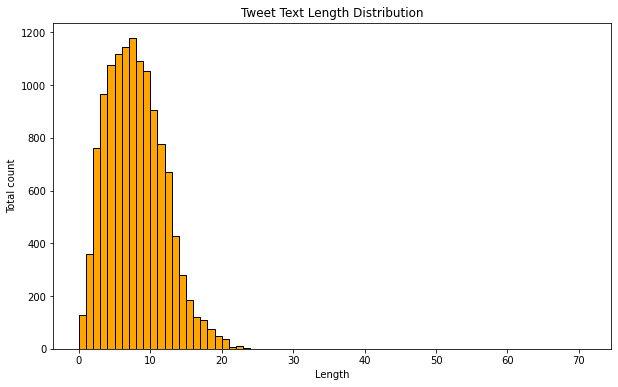

In [19]:
# plot the sentence length distribution

sentence_length = list()

def check_sentence_length(corpus):
    for sentence in corpus:
        sentence_length.append(len(sentence.split()))

check_sentence_length(truncated_df['tweetText'])
plt.figure(figsize=(10, 6))
plt.hist(sentence_length, bins=np.arange(min(sentence_length), max(sentence_length)),edgecolor='black',color='orange')
plt.title('Tweet Text Length Distribution')
plt.xlabel('Length')
plt.ylabel('Total count')

In [20]:
# perform label encoding on the labels and define X_train and y_train
label_encoder=LabelEncoder()
Y=truncated_df['label']
label_encoder.fit(Y)
label_encoder.classes_ = label_encoder.classes_[::-1]  #invert class such that fake class correspond to 1, real class corresppond to 0
y_train = label_encoder.transform(Y)
X_train = truncated_df['tweetText']
truncated_df['encodedLabel']= y_train
print(y_train)

[1 1 1 ... 1 1 1]


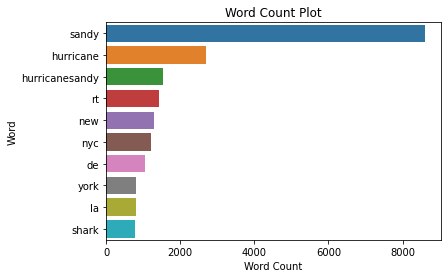

In [21]:
#plot word count plot showing the total occurence of each word
def wordCountplot(X_train):
    corpus_dict=dict()
    for sentence in X_train:
        for word in sentence.split():
            if word not in corpus_dict.keys():
                corpus_dict[word]=1
            else:
                corpus_dict[word]=corpus_dict[word]+1
                
    corpus=list()
    frequency=list()

    sorted_dict = sorted(corpus_dict.items(), key=lambda x:x[1],reverse=True )
    for keyValue in sorted_dict:
        word,wordCount = keyValue
        corpus.append(word)
        frequency.append(wordCount)
        
    sns.barplot(x=frequency[:10],y=corpus[:10])
    plt.title('Word Count Plot')
    plt.xlabel('Word Count')
    plt.ylabel('Word')

wordCountplot(X_train)

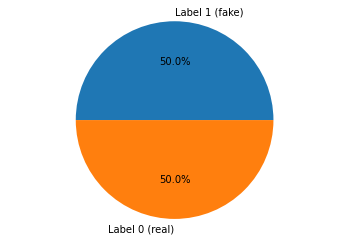

In [22]:
# perform SMOTE

# vectorise text sentences into vector representation
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_train_vect = X_train_vect.toarray()

# apply SMOTE algorithm to the vector representation
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_vect, y_train)

# Transform back to text representation
X_train_smote_text = vectorizer.inverse_transform(X_train_smote)

# join the words together to get back text sentences
X_train_smote_text = [" ".join(doc) for doc in X_train_smote_text]

# plot pie chart showing the distribution of each class
plt.pie(pd.value_counts(y_train_smote),
        labels=['Label 1 (fake)', 'Label 0 (real)'],
        autopct='%0.1f%%')
plt.axis('equal')
plt.show()

In [23]:
# define sentence transformer. The model is from Huggingface
encoder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = encoder.encode(X_train)
print(embeddings)

[[ 0.01409476  0.03766996 -0.0106725  ...  0.08241136 -0.0092758
  -0.03218764]
 [ 0.00465234  0.01884863  0.01465559 ...  0.06709281 -0.03373781
   0.00674749]
 [ 0.03081443  0.03713534  0.03735477 ...  0.03761739 -0.07212203
  -0.02399893]
 ...
 [-0.00222974 -0.00704658 -0.02832248 ... -0.00493244  0.01109471
  -0.0069859 ]
 [ 0.01948671  0.06916212  0.01219451 ...  0.04371995  0.04654327
  -0.06907506]
 [ 0.00351589 -0.00452263 -0.02420383 ... -0.00200538  0.02438565
  -0.00184693]]


# Test sentence embedding encoder

In [24]:
#define some text samples
sentence1="I am very happy"
sentence2="I am extremely happy"
sentence3="I am very sad"
sentence4=" I am nervous of tomorrow exam"

#encode each samples into vector representation
embedding1=encoder.encode(sentence1).reshape(1,-1)
embedding2=encoder.encode(sentence2).reshape(1,-1)
embedding3=encoder.encode(sentence3).reshape(1,-1)
embedding4=encoder.encode(sentence4).reshape(1,-1)

#calculate cosine similairy 
similarity_score1 = cosine_similarity(embedding1,embedding2)
similarity_score2 = cosine_similarity(embedding1,embedding3)
similarity_score3 = cosine_similarity(embedding1,embedding4)
print(similarity_score1)
print(similarity_score2)
print(similarity_score3)

[[0.937881]]
[[0.4533031]]
[[0.17820051]]


In [25]:
# reduce to 2-dimension for visualisation

pca = PCA(n_components=2)
embeddingCombine1 = np.array([embedding1,embedding2,embedding3,embedding4])
embeddingCombine1 = embeddingCombine1.squeeze()

embeddings2D = pca.fit_transform(embeddingCombine1)
print(embeddings2D)


[[-0.4307663  -0.21864817]
 [-0.42557785 -0.24082315]
 [ 0.01740259  0.7086029 ]
 [ 0.83894145 -0.2491316 ]]


Text(0.83894145, -0.2491316, ' I am nervous of tomorrow exam')

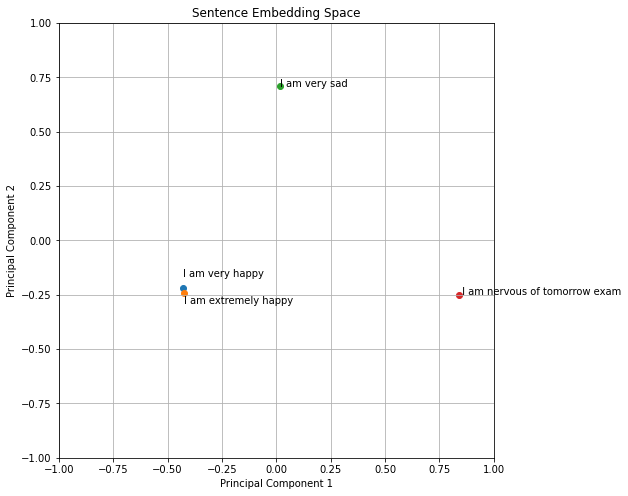

In [26]:
#plot the sentence embedding space
plt.figure(figsize=(10, 8))
plt.scatter(embeddings2D[0, 0], embeddings2D[0, 1])
plt.scatter(embeddings2D[1, 0], embeddings2D[1, 1])
plt.scatter(embeddings2D[2, 0], embeddings2D[2, 1])
plt.scatter(embeddings2D[3, 0], embeddings2D[3, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Sentence Embedding Space')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

plt.text(embeddings2D[0,0],embeddings2D[0,1]+0.05,sentence1)
plt.text(embeddings2D[1,0],embeddings2D[1,1]-0.05,sentence2)
plt.text(embeddings2D[2,0],embeddings2D[2,1],sentence3)
plt.text(embeddings2D[3,0],embeddings2D[3,1],sentence4)

In [27]:
'''
SVMpipeline = Pipeline([
    ('model', SVC(random_state=42))
])

param_grid = {
    'model__C': [0.1, 1, 10],  # Example C values, adjust based on your data
    'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel types to try
    'model__gamma': ['scale','auto']
}

# Initialize GridSearchCV with the pipeline and the parameter grid
grid_search = GridSearchCV(SVMpipeline,param_grid, cv=5, verbose=1, n_jobs=-1)

# Perform the grid search with your data
grid_search.fit(embeddings, y_train)

# Best parameter set found:
print("Best parameters found: ", grid_search.best_params_)

# Best estimator:
print("Best estimator: ", grid_search.best_estimator_)
'''


'\nSVMpipeline = Pipeline([\n    (\'model\', SVC(random_state=42))\n])\n\nparam_grid = {\n    \'model__C\': [0.1, 1, 10],  # Example C values, adjust based on your data\n    \'model__kernel\': [\'linear\', \'rbf\', \'poly\', \'sigmoid\'],  # Kernel types to try\n    \'model__gamma\': [\'scale\',\'auto\']\n}\n\n# Initialize GridSearchCV with the pipeline and the parameter grid\ngrid_search = GridSearchCV(SVMpipeline,param_grid, cv=5, verbose=1, n_jobs=-1)\n\n# Perform the grid search with your data\ngrid_search.fit(embeddings, y_train)\n\n# Best parameter set found:\nprint("Best parameters found: ", grid_search.best_params_)\n\n# Best estimator:\nprint("Best estimator: ", grid_search.best_estimator_)\n'

# Model Training

# First Design Iteration (TF-IDF vectorisation without SMOTE)

In [28]:
#Random Forest with TF-IDF
pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 1))),
    ('rf',RandomForestClassifier(random_state=42,n_estimators=100,criterion='entropy'))
])

pipeline1.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('rf',
                 RandomForestClassifier(criterion='entropy', random_state=42))])

In [29]:
#SVM with TF-IDF
pipeline2 = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 1))),
   ('svc', SVC(probability=True,C=1,kernel='rbf',gamma='scale', random_state=42))
])

pipeline2.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('svc', SVC(C=1, probability=True, random_state=42))])

# Second Design Iteration (Sentence Embedding without SMOTE)

In [30]:
#Random Forest with sentence embedding
model3 = RandomForestClassifier(random_state=42,n_estimators=100,criterion='entropy')
model3.fit(embeddings,y_train)                              

RandomForestClassifier(criterion='entropy', random_state=42)

In [31]:
#SVM with sentence embedding
model4 = SVC(probability=True,C=1,kernel='rbf',gamma='scale', random_state=42)
model4.fit(embeddings,y_train)

SVC(C=1, probability=True, random_state=42)

# Third Design Iteration (Sentence Embedding with SMOTE)

In [32]:
#generate sentence embedding for the dataset with oversampling
embeddings_smote = encoder.encode(X_train_smote_text)

In [33]:
#Random Forest with sentence embedding with SMOTE 
model5 = RandomForestClassifier(random_state=42,n_estimators=100,criterion='entropy')
model5.fit(embeddings_smote,y_train_smote)

RandomForestClassifier(criterion='entropy', random_state=42)

In [34]:
#SVM with sentence embeddings with SMOTE
model6 = SVC(probability=True,C=1,kernel='rbf',gamma='scale', random_state=42)
model6.fit(embeddings_smote,y_train_smote)

SVC(C=1, probability=True, random_state=42)

# Testing

In [35]:
# test data dataframe
testdf=pd.DataFrame(test_data_dict)
testdf

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,578854927457349632,kereeen RT @Shyman33: Eclipse from ISS.... htt...,70824972,eclipse_01,peay_s,Fri Mar 20 09:45:43 +0000 2015,fake
1,578874632670953472,Absolutely beautiful! RT @Shyman33: Eclipse fr...,344707006,eclipse_01,JaredUcanChange,Fri Mar 20 11:04:02 +0000 2015,fake
2,578891261353984000,“@Shyman33: Eclipse from ISS.... http://t.co/C...,224839607,eclipse_01,tpjp1231,Fri Mar 20 12:10:06 +0000 2015,fake
3,578846612312748032,Eclipse from ISS.... http://t.co/En87OtvsU6,134543073,eclipse_01,Shyman33,Fri Mar 20 09:12:41 +0000 2015,fake
4,578975333841551360,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,1150728872,eclipse_01,Epimethee_,Fri Mar 20 17:44:11 +0000 2015,fake
...,...,...,...,...,...,...,...
3776,578433150071775232,Un présentateur de la ZDF confesse avoir truqu...,257551211,varoufakis_1,Cdt_Sylvestre,Thu Mar 19 05:49:44 +0000 2015,fake
3777,578433646597656576,Oh les kleine menteurs @CorineBarella: Un prés...,27575883,varoufakis_1,damomarc,Thu Mar 19 05:51:42 +0000 2015,fake
3778,578486910491996160,Este es el programa de ZDF en el que confirman...,2049211,varoufakis_1,javierpascual,Thu Mar 19 09:23:21 +0000 2015,fake
3779,578505023912591360,11.34 - wir haben FAST Mittag ▶ Riesen Verwirr...,262222386,varoufakis_1,aotto1968_2,Thu Mar 19 10:35:20 +0000 2015,fake


In [36]:
#applying preprocesing steps to test data
testdf['tweetText']=testdf['tweetText'].apply(clean_text)
testdf['tweetText']=testdf['tweetText'].apply(lemmatization)
testdf['tweetText']=testdf['tweetText'].apply(remove_stopwords)

In [37]:
#converting X test to list and label encoded y test
X_test=testdf['tweetText'].tolist()
y_test=testdf['label'].tolist()
y_test=label_encoder.transform(y_test)
X_test_encoded =encoder.encode(X_test)

# First Design Iteration Testing

              precision    recall  f1-score   support

           0       0.39      0.06      0.10      1217
           1       0.68      0.96      0.80      2564

    accuracy                           0.67      3781
   macro avg       0.53      0.51      0.45      3781
weighted avg       0.59      0.67      0.57      3781



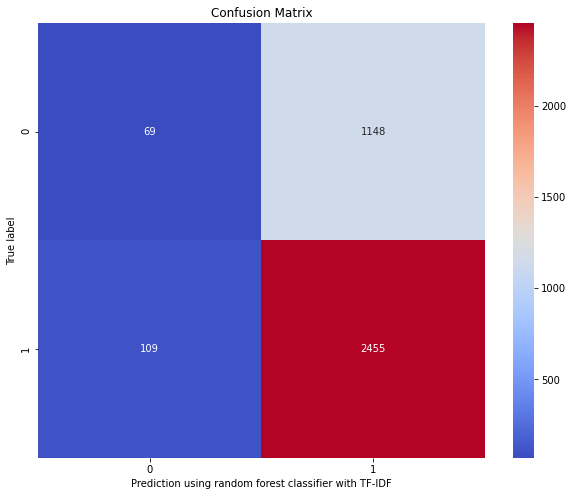

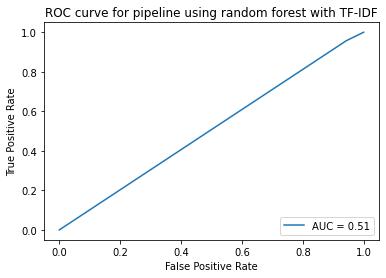

In [38]:
#perform model prediction on test data
test_prediction1 = pipeline1.predict(X_test)

#display classification report for error analysis
print(classification_report(y_test,test_prediction1))

#plot the confusion matrix
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,test_prediction1),annot=True,fmt="d",cmap="coolwarm")
ax = ax.set(xlabel='Prediction using random forest classifier with TF-IDF',ylabel='True label',title='Confusion Matrix')

#plot the ROC curve
fpr1, tpr1, thresholds1 = roc_curve(y_test, test_prediction1)
roc_auc1 = auc(fpr1, tpr1)
ROC_curve1=RocCurveDisplay(fpr=fpr1, tpr=tpr1, roc_auc=roc_auc1)
ROC_curve1.plot()
plt.title('ROC curve for pipeline using random forest with TF-IDF')
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.65      0.73      1217
           1       0.85      0.93      0.89      2564

    accuracy                           0.84      3781
   macro avg       0.84      0.79      0.81      3781
weighted avg       0.84      0.84      0.84      3781



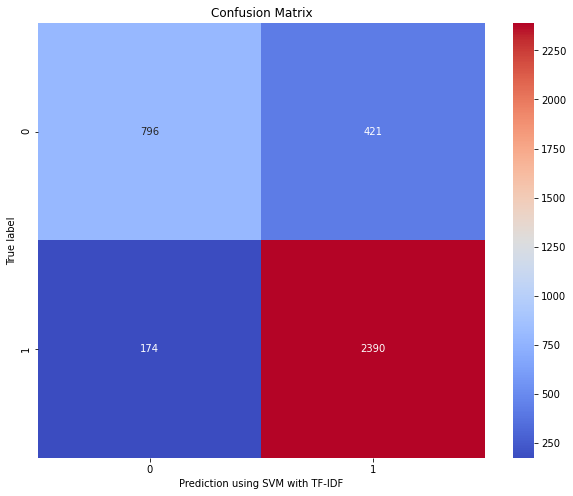

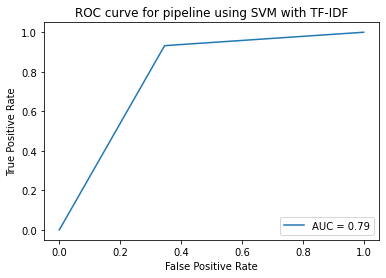

In [39]:
#perform model prediction on test data
test_prediction2 = pipeline2.predict(X_test)

#dislay classification report for error analysis
print(classification_report(y_test,test_prediction2))

#plot confusion matrix
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,test_prediction2),annot=True,fmt="d",cmap="coolwarm")
ax = ax.set(xlabel='Prediction using SVM with TF-IDF',ylabel='True label',title='Confusion Matrix')

#plot ROC curve
fpr2, tpr2, thresholds2 = roc_curve(y_test, test_prediction2)
roc_auc2 = auc(fpr2, tpr2)
ROC_curve2=RocCurveDisplay(fpr=fpr2, tpr=tpr2, roc_auc=roc_auc2)
ROC_curve2.plot()
plt.title('ROC curve for pipeline using SVM with TF-IDF')
plt.show()

# Second Design Iteration Testing

              precision    recall  f1-score   support

           0       0.56      0.03      0.05      1217
           1       0.68      0.99      0.81      2564

    accuracy                           0.68      3781
   macro avg       0.62      0.51      0.43      3781
weighted avg       0.64      0.68      0.56      3781



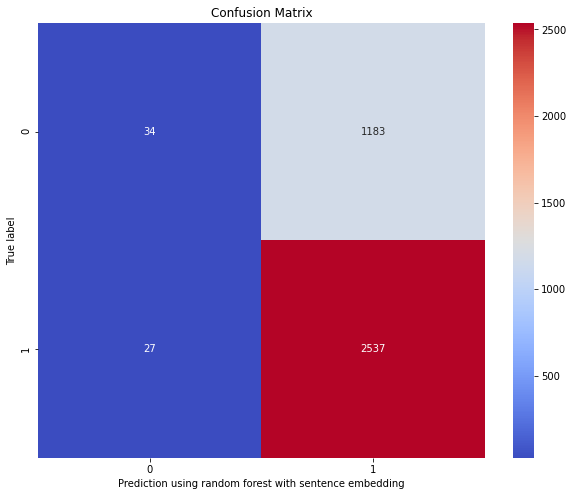

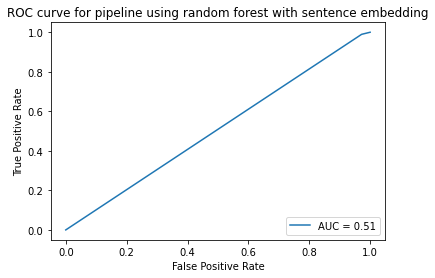

In [40]:
#perform model prediction on test data
test_prediction3 = model3.predict(X_test_encoded)

#display classification report for error analysis
print(classification_report(y_test,test_prediction3))

#plot confusion matrix
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,test_prediction3),annot=True,fmt="d",cmap="coolwarm")
ax = ax.set(xlabel='Prediction using random forest with sentence embedding',ylabel='True label',title='Confusion Matrix')

#plot ROC curve
fpr3, tpr3, thresholds3 = roc_curve(y_test, test_prediction3)
roc_auc3 = auc(fpr3, tpr3)
ROC_curve3=RocCurveDisplay(fpr=fpr3, tpr=tpr3, roc_auc=roc_auc3)
ROC_curve3.plot()
plt.title('ROC curve for pipeline using random forest with sentence embedding')
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1217
           1       0.94      0.94      0.94      2564

    accuracy                           0.92      3781
   macro avg       0.91      0.90      0.91      3781
weighted avg       0.92      0.92      0.92      3781



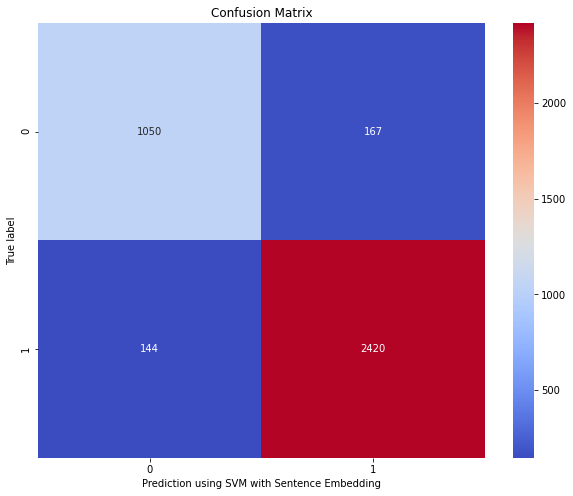

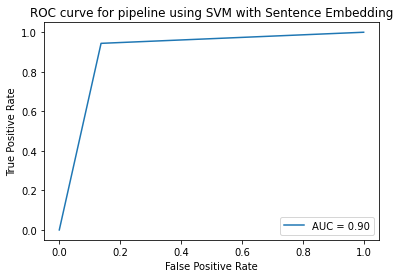

In [41]:
#perform model prediction on test data
test_prediction4 = model4.predict(X_test_encoded)

#display classification report for error analysis
print(classification_report(y_test,test_prediction4))

#plot confusion matrix
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,test_prediction4),annot=True,fmt="d",cmap="coolwarm")
ax = ax.set(xlabel='Prediction using SVM with Sentence Embedding',ylabel='True label',title='Confusion Matrix')

#plot ROC curve
fpr4, tpr4, thresholds4= roc_curve(y_test, test_prediction4)
roc_auc4 = auc(fpr4, tpr4)
ROC_curve4=RocCurveDisplay(fpr=fpr4, tpr=tpr4, roc_auc=roc_auc4)
ROC_curve4.plot()
plt.title('ROC curve for pipeline using SVM with Sentence Embedding')
plt.show()

# Third Design iteration testing

              precision    recall  f1-score   support

           0       0.95      0.64      0.77      1217
           1       0.85      0.99      0.91      2564

    accuracy                           0.88      3781
   macro avg       0.90      0.81      0.84      3781
weighted avg       0.89      0.88      0.87      3781



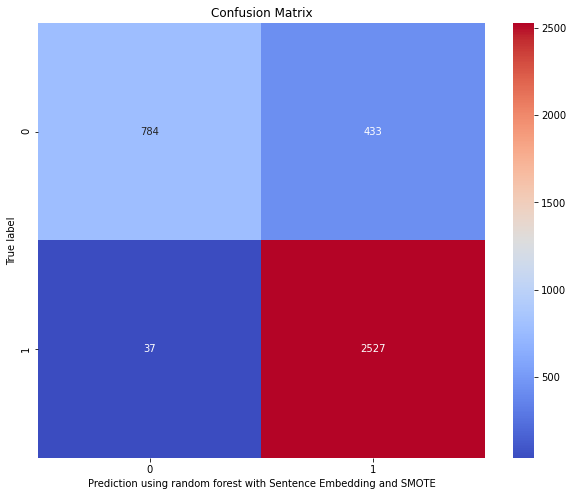

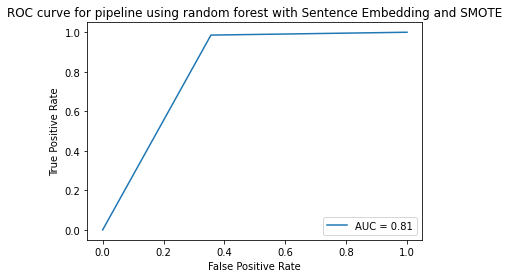

In [42]:
#perform model prediction on test data
test_prediction5 = model5.predict(X_test_encoded)

#display classification report for error analysis
print(classification_report(y_test,test_prediction5))

#plot confusion matrix
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,test_prediction5),annot=True,fmt="d",cmap="coolwarm")
ax = ax.set(xlabel='Prediction using random forest with Sentence Embedding and SMOTE',ylabel='True label',title='Confusion Matrix')

#plot ROC curve
fpr5, tpr5, thresholds5= roc_curve(y_test, test_prediction5)
roc_auc5 = auc(fpr5, tpr5)
ROC_curve5=RocCurveDisplay(fpr=fpr5, tpr=tpr5, roc_auc=roc_auc5)
ROC_curve5.plot()
plt.title('ROC curve for pipeline using random forest with Sentence Embedding and SMOTE')
plt.show()

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1217
           1       0.94      0.94      0.94      2564

    accuracy                           0.92      3781
   macro avg       0.90      0.90      0.90      3781
weighted avg       0.92      0.92      0.92      3781



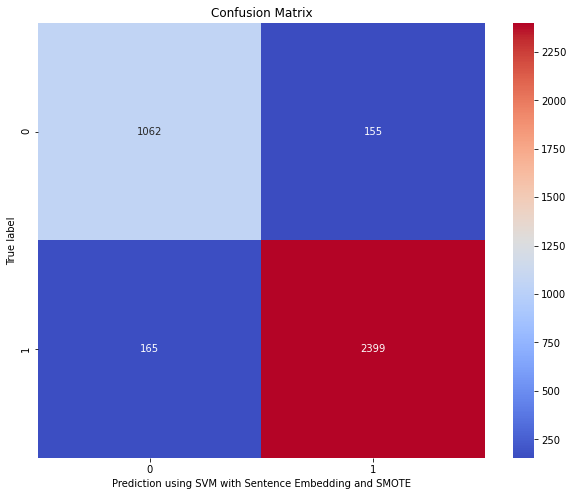

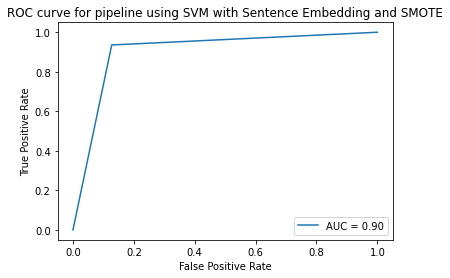

In [43]:
#perform model prediction on test data
test_prediction6 = model6.predict(X_test_encoded)

#display classification report for error analysis
print(classification_report(y_test,test_prediction6))

#display the confusion matrix
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,test_prediction6),annot=True,fmt="d",cmap="coolwarm")
ax = ax.set(xlabel='Prediction using SVM with Sentence Embedding and SMOTE',ylabel='True label',title='Confusion Matrix')

#plot the ROC curve
fpr6, tpr6, thresholds6= roc_curve(y_test, test_prediction6)
roc_auc6 = auc(fpr6, tpr6)
ROC_curve6=RocCurveDisplay(fpr=fpr6, tpr=tpr6, roc_auc=roc_auc6)
ROC_curve6.plot()
plt.title('ROC curve for pipeline using SVM with Sentence Embedding and SMOTE')
plt.show()